In [1]:
from GoldGridworld import *
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pylab as plt
import torch.nn as nn
from collections import deque
import copy
import random
from tqdm import tqdm

In [2]:
action_set = {0:'r', 1:'d'}

In [3]:
l1 = 32
l2 = 256
l3 = 128
l4 = 2

model = nn.Sequential(
    nn.Linear(l1, l2),
    nn.ReLU(),
    nn.Linear(l2, l3),
    nn.ReLU(),
    nn.Linear(l3,l4))

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
gamma = 0.9
epsilon = 0.3

epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 7
h = 0
sync_freq = 500 #A
j=0
for i in tqdm(range(epochs)):
    game = GoldGridworld(4, 'random', 5)
    state1 = game.get_state()
    state1 += torch.rand_like(state1)/10
    mov = 0
    done = False
    while(not done and mov < max_moves): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,2)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        reward = game.move(action)
        
        state2 = game.get_state()
        state2 += torch.rand_like(state1)/10
        
        done = game.is_finished()
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            # print(i, loss.item())
            # clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

100%|██████████| 5000/5000 [03:01<00:00, 27.62it/s]


Text(0, 0.5, 'Loss')

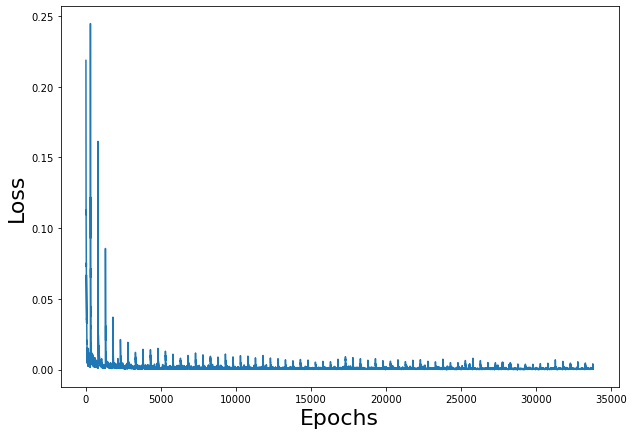

In [5]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [6]:
def test_model(model,size, mode, num_coins, display=True):
    cumulative_reward = 0
    test_game = GoldGridworld(size,mode,num_coins)
    state = test_game.get_state()
    state += torch.rand_like(state)/10
    if display:
        print("Initial State:")
        test_game.display()
    for i in range(7):
        qval = model(state)
        action = action_set[torch.argmax(qval,dim=1).item()]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        cumulative_reward += test_game.move(action)
        
        state = test_game.get_state()
        state += torch.rand_like(state)/10
        
        if display:
            test_game.display()

        if test_game.is_finished():
            if display:
                print(f"Game finished with reward:{cumulative_reward}")
            return cumulative_reward
    if display:
        print("Game terminated; too many moves.")
    return 0

In [7]:
test_model(model, size=4, mode='random', num_coins=5, display=True)

Initial State:
[['P' ' ' ' ' ' ']
 ['$' '$' '$' ' ']
 [' ' '$' ' ' ' ']
 ['$' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 ['P' '$' '$' ' ']
 [' ' '$' ' ' ' ']
 ['$' ' ' ' ' ' ']]
Move #: 1; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' 'P' '$' ' ']
 [' ' '$' ' ' ' ']
 ['$' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' '$' ' ']
 [' ' 'P' ' ' ' ']
 ['$' ' ' ' ' ' ']]
Move #: 3; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' '$' ' ']
 [' ' ' ' 'P' ' ']
 ['$' ' ' ' ' ' ']]
Move #: 4; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' '$' ' ']
 [' ' ' ' ' ' 'P']
 ['$' ' ' ' ' ' ']]
Move #: 5; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' '$' ' ']
 [' ' ' ' ' ' ' ']
 ['$' ' ' ' ' 'P']]
Game finished with reward:3


3

In [8]:
max_games = 1000
collected_coins = 0
for i in range(max_games):
    collected_coins += test_model(model, size=4, mode='random', num_coins=5, display=False)
score = collected_coins / (5 * max_games)
print("Games played: {0}, # of coins collected: {1}".format(max_games,collected_coins))
print("percentage of coins collected: {:.2f}%".format(100.0*score))

Games played: 1000, # of coins collected: 1586
percentage of coins collected: 31.72%
